In [1]:
import pandas as pd
import time
import datetime
import collections
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("training_set_VU_DM.csv")
df_test = pd.read_csv("test_set_VU_DM.csv")
#df = pd.read_csv("sample_training_set.csv")

# Get a sample from the training dataset
#df = df.sample(n=500000)
#df.to_csv('sample_training_set.csv')

In [3]:
# Make a descriptive dataframe
df_descr = pd.concat([df.nunique(), df.isna().sum(), df.notna().sum(), df.dtypes, df.max(), df.min()], axis=1)
df_descr.columns = ['Unique values', 'NaN count', 'non NaN count', 'Datatype', 'Max value', 'Min value']
df_descr

,Unique values,NaN count,non NaN count,Datatype,Max value,Min value
srch_id,199795,0,4958347,int64,332785,1
date_time,198615,0,4958347,object,2013-06-30 23:58:24,2012-11-01 00:08:29
site_id,34,0,4958347,int64,34,1
visitor_location_country_id,210,0,4958347,int64,231,1
visitor_hist_starrating,312,4706481,251866,float64,5.0,1.41
visitor_hist_adr_usd,7799,4705359,252988,float64,1958.7,0.0
prop_country_id,172,0,4958347,int64,230,1
prop_id,129113,0,4958347,int64,140821,1
prop_starrating,6,0,4958347,int64,5,0
prop_review_score,10,7364,4950983,float64,5.0,0.0


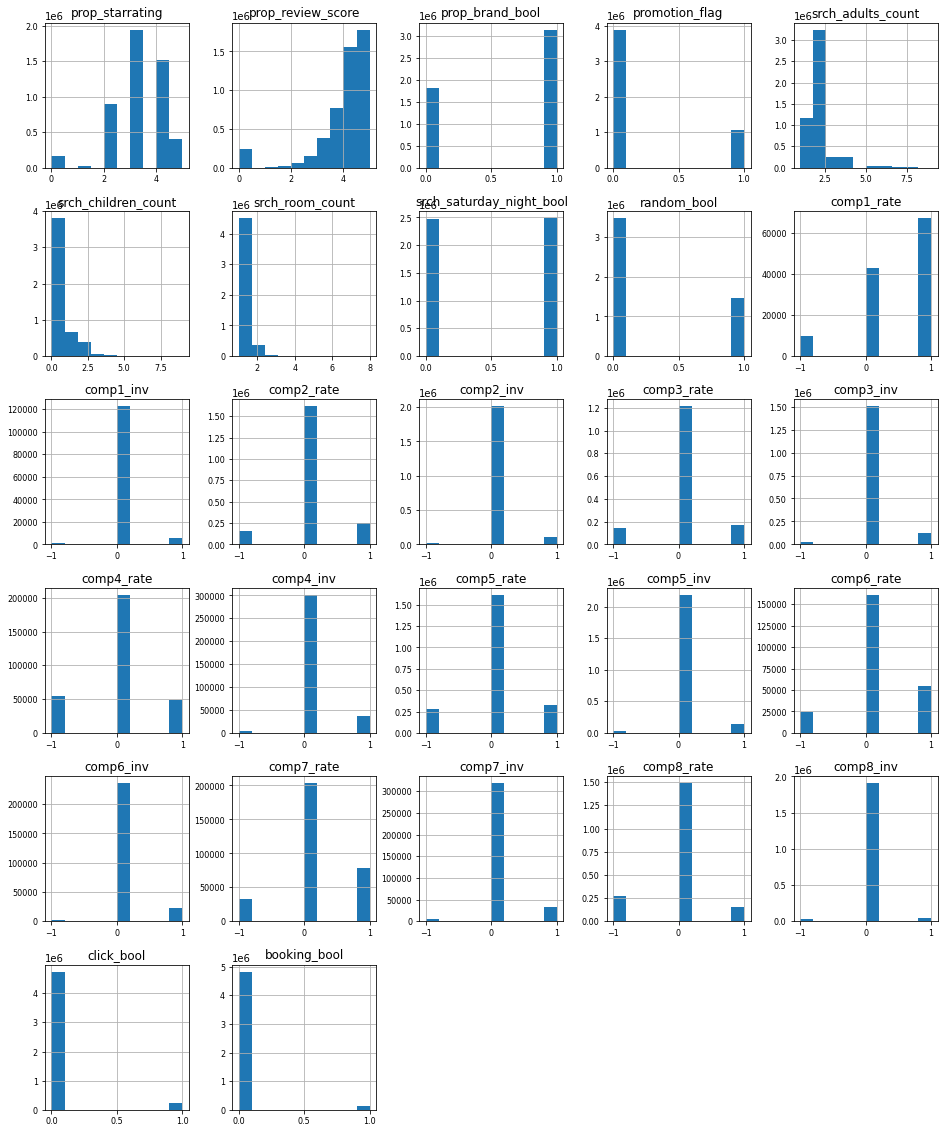

In [4]:
descr2 = df_descr[df_descr['Unique values'] <= 10].index.tolist() # (almost) all are categorical variables
descr3 = df_descr[df_descr['Unique values'] > 50].index.tolist() # (almost) all are numerical variables


df[descr2].hist(figsize=(16, 20), bins=10, xlabelsize=8, ylabelsize=8)
descr3.remove('date_time')
descr3.remove('srch_id')
#df.boxplot(column=descr3, figsize=(16, 20))

In [5]:
#df[descr2].hist(figsize=(16, 20), bins=10, xlabelsize=8, ylabelsize=8)

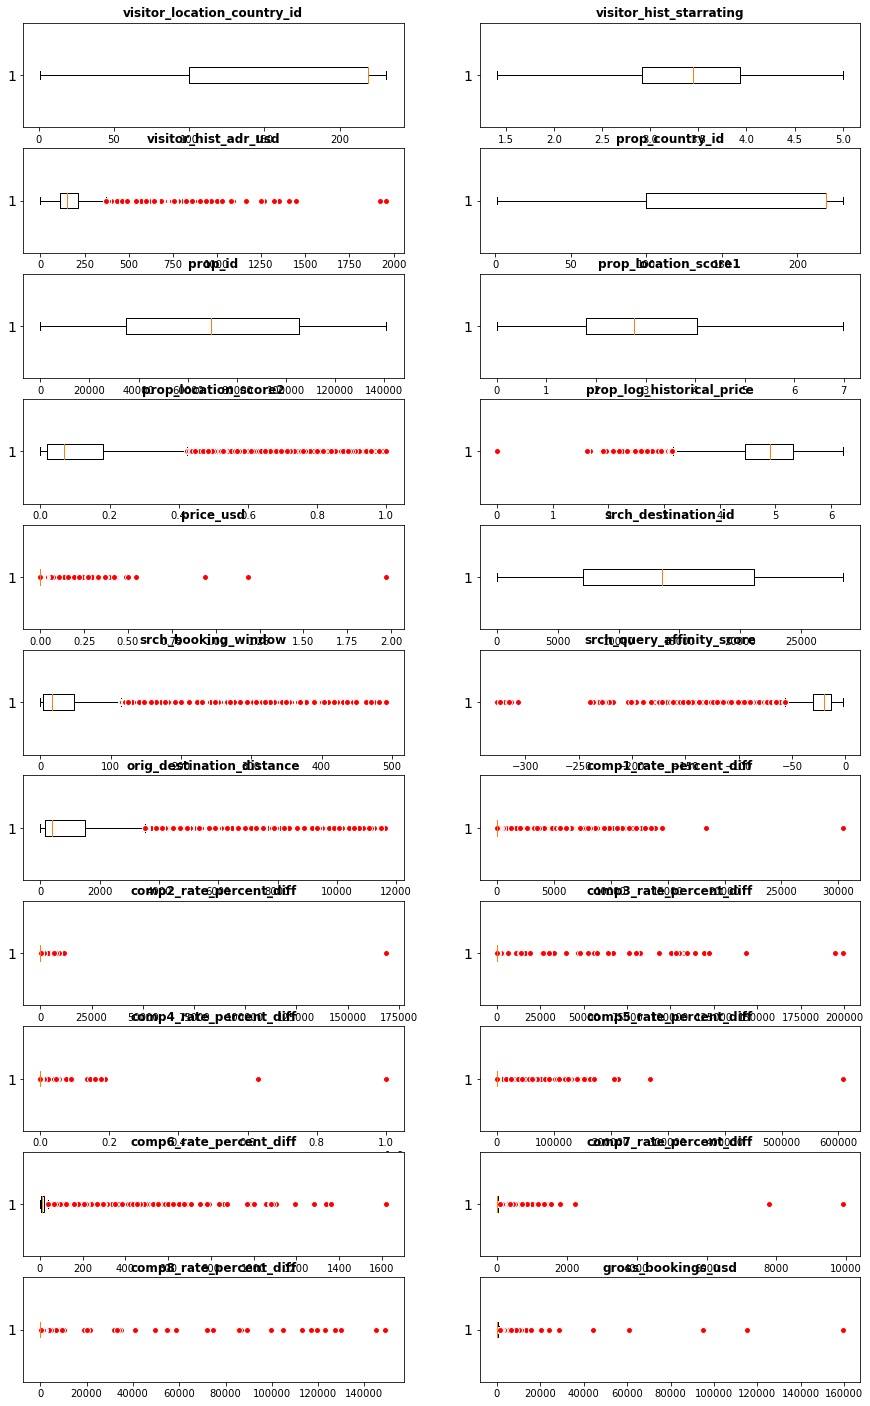

In [6]:
df_numerical = df[descr3]

red_circle = dict(markerfacecolor = 'red', marker = 'o', markeredgecolor = 'white')

fig, axs = plt.subplots(11, 2, figsize=(15,25))

for i, ax in enumerate(axs.flat):
    ax.boxplot(df_numerical.iloc[:,i].dropna(), flierprops = red_circle, vert=False)
    ax.set_title(df_numerical.columns[i], fontweight = 'bold')
    ax.tick_params(axis = 'y', labelsize = 14)

plt.show()

<AxesSubplot:>

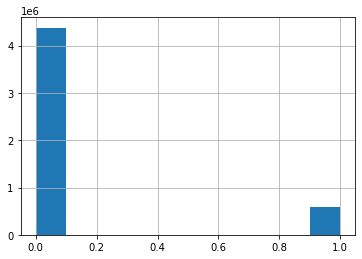

In [7]:
conditions = [(df['comp1_rate'].eq(-1) & df['comp1_inv'].ne(1)), 
              (df['comp2_rate'].eq(-1) & df['comp2_inv'].ne(1)), 
              (df['comp3_rate'].eq(-1) & df['comp3_inv'].ne(1)),  
              (df['comp4_rate'].eq(-1) & df['comp4_inv'].ne(1)), 
              (df['comp5_rate'].eq(-1) & df['comp5_inv'].ne(1)), 
              (df['comp6_rate'].eq(-1) & df['comp6_inv'].ne(1)), 
              (df['comp7_rate'].eq(-1) & df['comp7_inv'].ne(1)),  
              (df['comp8_rate'].eq(-1) & df['comp8_inv'].ne(1))]

choices = [1,1,1,1,1,1,1,1]

df['comp_cheaper'] = np.select(conditions, choices, default=0)

# and for test set
conditions2 = [(df_test['comp1_rate'].eq(-1) & df_test['comp1_inv'].ne(1)), 
              (df_test['comp2_rate'].eq(-1) & df_test['comp2_inv'].ne(1)), 
              (df_test['comp3_rate'].eq(-1) & df_test['comp3_inv'].ne(1)),  
              (df_test['comp4_rate'].eq(-1) & df_test['comp4_inv'].ne(1)), 
              (df_test['comp5_rate'].eq(-1) & df_test['comp5_inv'].ne(1)), 
              (df_test['comp6_rate'].eq(-1) & df_test['comp6_inv'].ne(1)), 
              (df_test['comp7_rate'].eq(-1) & df_test['comp7_inv'].ne(1)),  
              (df_test['comp8_rate'].eq(-1) & df_test['comp8_inv'].ne(1))]

choices2 = [1,1,1,1,1,1,1,1]

df_test['comp_cheaper'] = np.select(conditions2, choices2, default=0)
df_test['comp_cheaper'].hist()

In [8]:
# # combine comp 1-8 in variable bool whether booking is cheapest on booking.com or not
# # if cheaper and availible than yes/1
# df['comp_cheaper'] = np.nan
# for i in range(0,len(df),1):
#     if (df.at[i,'comp1_rate'] == -1 and df.at[i,'comp1_inv'] != 1) or (df.at[i,'comp2_rate'] == -1 and df.at[i,'comp2_inv'] != 1) or (df.at[i,'comp3_rate'] == -1 and df.at[i,'comp3_inv'] != 1) or (df.at[i,'comp4_rate'] == -1 and df.at[i,'comp4_inv'] != 1) or (df.at[i,'comp5_rate'] == -1 and df.at[i,'comp5_inv'] != 1) or (df.at[i,'comp6_rate'] == -1 and df.at[i,'comp6_inv'] != 1) or (df.at[i,'comp7_rate'] == -1 and df.at[i,'comp7_inv'] != 1) or (df.at[i,'comp8_rate'] == -1 and df.at[i,'comp8_inv'] != 1):
#         df.at[i,'comp_cheaper'] = 1
#     else:
#         df.at[i,'comp_cheaper'] = 0
# df['comp_cheaper'].hist() # 582754 1 en 4375593 0

# # comp cheaper for test df
# df_test['comp_cheaper'] = np.nan
# for i in range(0,len(df_test),1):
#     if (df_test.at[i,'comp1_rate'] == -1 and df_test.at[i,'comp1_inv'] != 1) or (df_test.at[i,'comp2_rate'] == -1 and df_test.at[i,'comp2_inv'] != 1) or (df_test.at[i,'comp3_rate'] == -1 and df_test.at[i,'comp3_inv'] != 1) or (df_test.at[i,'comp4_rate'] == -1 and df_test.at[i,'comp4_inv'] != 1) or (df_test.at[i,'comp5_rate'] == -1 and df_test.at[i,'comp5_inv'] != 1) or (df_test.at[i,'comp6_rate'] == -1 and df_test.at[i,'comp6_inv'] != 1) or (df_test.at[i,'comp7_rate'] == -1 and df_test.at[i,'comp7_inv'] != 1) or (df_test.at[i,'comp8_rate'] == -1 and df_test.at[i,'comp8_inv'] != 1):
#         df_test.at[i,'comp_cheaper'] = 1
#     else:
#         df_test.at[i,'comp_cheaper'] = 0
# df_test['comp_cheaper'].hist() # 580166 1 and 4378181 0

In [9]:
df['srch_query_affinity_score'] = np.exp(df['srch_query_affinity_score'])
df_test['srch_query_affinity_score'] = np.exp(df_test['srch_query_affinity_score'])

In [10]:
for c in df.columns:
    if c == 'prop_review_score':
        df[c] = df[c].fillna(df[c].mode()[0])
    elif c == 'prop_location_score2':
        df.loc[df.loc[:,c].isnull(),c]=df.loc[:,c].mean()
    elif c == 'orig_destination_distance':
        df.loc[df.loc[:,c].isnull(),c]=df.loc[:,c].mean()
    elif c == 'gross_bookings_usd':
        df.loc[df.loc[:,c].isnull(),c]=df.loc[:,c].median()
    elif c == 'srch_query_affinity_score':
        df.loc[df.loc[:,c].isnull(),c]=df.loc[:,c].median()

for c in df_test.columns:
    if c == 'prop_review_score':
        df_test[c] = df_test[c].fillna(df_test[c].mode()[0])
    elif c == 'prop_location_score2':
        df_test.loc[df_test.loc[:,c].isnull(),c]=df_test.loc[:,c].mean()
    elif c == 'orig_destination_distance':
        df_test.loc[df_test.loc[:,c].isnull(),c]=df_test.loc[:,c].mean()
    elif c == 'gross_bookings_usd':
        df_test.loc[df_test.loc[:,c].isnull(),c]=df_test.loc[:,c].median()
    elif c == 'srch_query_affinity_score':
        df_test.loc[df_test.loc[:,c].isnull(),c]=df_test.loc[:,c].median()
        
        

print("count of NULL values after imputation\n")
print(df['prop_review_score'].isnull().sum())
print(df['prop_location_score2'].isnull().sum())   
print(df['gross_bookings_usd'].isnull().sum())

count of NULL values after imputation

0
0
0


In [11]:
previously_purchased_hotels_train = []
columns = ['visitor_hist_starrating', 'visitor_hist_adr_usd']
for i in df['visitor_hist_starrating'].values:
    if i >= 0:
        previously_purchased_hotels_train.append(1)
    else:
        previously_purchased_hotels_train.append(0)
        
previously_purchased_hotels_test = []

for i in df_test['visitor_hist_starrating'].values:
    if i >= 0:
        previously_purchased_hotels_test.append(1)
    else:
        previously_purchased_hotels_test.append(0)


In [12]:
df.drop('visitor_hist_starrating', inplace = True, axis =1)
df.drop('visitor_hist_adr_usd', inplace = True, axis = 1)
df_test.drop('visitor_hist_starrating', inplace = True, axis =1)
df_test.drop('visitor_hist_adr_usd', inplace = True, axis = 1)
df.insert(6, 'visitor_hist_bool', previously_purchased_hotels_train)
df_test.insert(6, 'visitor_hist_bool', previously_purchased_hotels_test)
df.columns

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'prop_country_id', 'prop_id', 'visitor_hist_bool', 'prop_starrating',
       'prop_review_score', 'prop_brand_bool', 'prop_location_score1',
       'prop_location_score2', 'prop_log_historical_price', 'position',
       'price_usd', 'promotion_flag', 'srch_destination_id',
       'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count',
       'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool',
       'srch_query_affinity_score', 'orig_destination_distance', 'random_bool',
       'comp1_rate', 'comp1_inv', 'comp1_rate_percent_diff', 'comp2_rate',
       'comp2_inv', 'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv',
       'comp7_rate_per

In [13]:
# For train set
adults = df['srch_adults_count'].values
children = df['srch_children_count'].values

adults = list(adults)
children = list(children)

ratio_adults = [i/ (i+j) for i, j in zip(adults, children)]

df.drop('srch_adults_count', inplace=True, axis=1)
df.drop('srch_children_count', inplace=True, axis=1)
df.insert(22, 'adult_ratio', ratio_adults)

# For test set

adults = df_test['srch_adults_count'].values
children = df_test['srch_children_count'].values

adults = list(adults)
children = list(children)

ratio_adults = [i/ (i+j) for i, j in zip(adults, children)]

df_test.drop('srch_adults_count', inplace=True, axis=1)
df_test.drop('srch_children_count', inplace=True, axis=1)
df_test.insert(22, 'adult_ratio', ratio_adults)

In [14]:
print(len(df.columns), len(df_test.columns))

53 49


In [15]:
df.columns

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'prop_country_id', 'prop_id', 'visitor_hist_bool', 'prop_starrating',
       'prop_review_score', 'prop_brand_bool', 'prop_location_score1',
       'prop_location_score2', 'prop_log_historical_price', 'position',
       'price_usd', 'promotion_flag', 'srch_destination_id',
       'srch_length_of_stay', 'srch_booking_window', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score', 'adult_ratio',
       'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv',
       'comp7_rate_percent_diff', 'comp8_rate', 'co

In [16]:
# Drop the comp rate columns to save storage, as we created new column for this and 
df = df.drop(['comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv',
       'comp7_rate_percent_diff', 'comp8_rate', 'comp8_inv',
       'comp8_rate_percent_diff'], axis=1)

df_test = df_test.drop(['comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv',
       'comp7_rate_percent_diff', 'comp8_rate', 'comp8_inv',
       'comp8_rate_percent_diff'], axis=1)


In [17]:
one_user = df[df['srch_id']==23423]
one_user[['position', 'booking_bool']]

,position,booking_bool
349304,28,0
349305,9,0
349306,29,0
349307,16,0
349308,24,0
349309,12,0
349310,27,0
349311,25,0
349312,10,0
349313,20,0


In [18]:
print(df.columns)

df_descr_two = pd.concat([df.nunique(), df.isna().sum(), df.notna().sum(), df.dtypes, df.max(), df.min()], axis=1)
df_descr_two.columns = ['Unique values', 'NaN count', 'non NaN count', 'Datatype', 'Max value', 'Min value']
df_descr_two

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'prop_country_id', 'prop_id', 'visitor_hist_bool', 'prop_starrating',
       'prop_review_score', 'prop_brand_bool', 'prop_location_score1',
       'prop_location_score2', 'prop_log_historical_price', 'position',
       'price_usd', 'promotion_flag', 'srch_destination_id',
       'srch_length_of_stay', 'srch_booking_window', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score', 'adult_ratio',
       'orig_destination_distance', 'random_bool', 'click_bool',
       'gross_bookings_usd', 'booking_bool', 'comp_cheaper'],
      dtype='object')


,Unique values,NaN count,non NaN count,Datatype,Max value,Min value
srch_id,199795,0,4958347,int64,332785,1
date_time,198615,0,4958347,object,2013-06-30 23:58:24,2012-11-01 00:08:29
site_id,34,0,4958347,int64,34,1
visitor_location_country_id,210,0,4958347,int64,231,1
prop_country_id,172,0,4958347,int64,230,1
prop_id,129113,0,4958347,int64,140821,1
visitor_hist_bool,2,0,4958347,int64,1,0
prop_starrating,6,0,4958347,int64,5,0
prop_review_score,10,0,4958347,float64,5.0,0.0
prop_brand_bool,2,0,4958347,int64,1,0


#  ----------------------------------XGBoost------------------------------------------------------------

In [20]:
# Make training and validation split - based on search id

# we exclude the columns that are not in the test set

df1 = df[df['srch_id']<= 200000]
df2 = df[df['srch_id']> 200000]

X_train = df1.loc[:, df1.columns.isin(['site_id', 'visitor_location_country_id',
       'prop_country_id', 'prop_id', 'visitor_hist_bool', 'prop_starrating',
       'prop_review_score', 'prop_brand_bool', 'prop_location_score1',
       'prop_location_score2', 'prop_log_historical_price',
       'price_usd', 'promotion_flag', 'srch_destination_id',
       'srch_length_of_stay', 'srch_booking_window', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score', 'adult_ratio',
       'orig_destination_distance', 'random_bool', 'comp_cheaper'])]
y_train = df1.loc[:, df1.columns.isin(['booking_bool'])]

X_val = df2.loc[:, df2.columns.isin(['site_id', 'visitor_location_country_id',
       'prop_country_id', 'prop_id', 'visitor_hist_bool', 'prop_starrating',
       'prop_review_score', 'prop_brand_bool', 'prop_location_score1',
       'prop_location_score2', 'prop_log_historical_price',
       'price_usd', 'promotion_flag', 'srch_destination_id',
       'srch_length_of_stay', 'srch_booking_window', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score', 'adult_ratio',
       'orig_destination_distance', 'random_bool', 'comp_cheaper'])]
y_val = df2.loc[:, df2.columns.isin(['booking_bool'])]

print(X_train.shape, X_val.shape)
# Set some features to type category to help xgboost
X_train[['site_id', 'prop_id','visitor_location_country_id','prop_review_score',
       'prop_country_id', 'prop_starrating', 'prop_brand_bool', 'promotion_flag', 'srch_destination_id', 
        'srch_length_of_stay', 'srch_booking_window', 'srch_room_count', 
         'srch_saturday_night_bool', 'random_bool']].astype("category")
X_val[['site_id', 'prop_id','visitor_location_country_id','prop_review_score',
       'prop_country_id', 'prop_starrating', 'prop_brand_bool', 'promotion_flag', 'srch_destination_id', 
        'srch_length_of_stay', 'srch_booking_window', 'srch_room_count', 
         'srch_saturday_night_bool', 'random_bool']].astype("category")
print('done')

(2978462, 23) (1979885, 23)
done


In [21]:
# Fit and train the model
clf2 = xgb.XGBClassifier(tree_method="approx", enable_categorical=True, use_label_encoder=False, max_depth=5)
clf2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [22]:
# Score the training data
print(clf2.feature_names_in_)
print(clf2.feature_importances_)
score = clf2.score(X_train, y_train, sample_weight=None)
print('Accuracy Training: ', score)
XGB_prob = clf2.predict_proba(X_train)
print("Booked or not:", clf2.classes_)
print("Probabilities of being booked:", XGB_prob[:,1])
df_train_result = df1.loc[:, df1.columns.isin(['srch_id', 'prop_id', 'booking_bool', 'position'])]
df_train_result['booking_pred_prob'] = XGB_prob[:,1]
df_sorted_train = df_train_result.sort_values(["srch_id", "booking_pred_prob"], ascending=[True, False])
df_sorted_train[['srch_id', 'prop_id', "booking_pred_prob", 'booking_bool', 'position']]
df_sorted_train['position_rank'] = df_sorted_train.groupby('srch_id')['booking_pred_prob'].rank(ascending=False)
df_sorted_train

['site_id' 'visitor_location_country_id' 'prop_country_id' 'prop_id'
 'visitor_hist_bool' 'prop_starrating' 'prop_review_score'
 'prop_brand_bool' 'prop_location_score1' 'prop_location_score2'
 'prop_log_historical_price' 'price_usd' 'promotion_flag'
 'srch_destination_id' 'srch_length_of_stay' 'srch_booking_window'
 'srch_room_count' 'srch_saturday_night_bool' 'srch_query_affinity_score'
 'adult_ratio' 'orig_destination_distance' 'random_bool' 'comp_cheaper']
[0.00721226 0.00669616 0.01192249 0.0059908  0.00899699 0.04299915
 0.02307532 0.01362144 0.05299533 0.07022735 0.0113929  0.02464268
 0.0623572  0.00860894 0.01204045 0.00912735 0.02385683 0.00707347
 0.00805819 0.02742767 0.00875226 0.53334486 0.01957992]
Accuracy Training:  0.9721879950121909
Booked or not: [0 1]
Probabilities of being booked: [0.01035172 0.00521947 0.00380169 ... 0.03323133 0.0120526  0.03877141]


C:\Users\Wiebe\AppData\Local\Temp\ipykernel_7872\33990949.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_result['booking_pred_prob'] = XGB_prob[:,1]


,srch_id,prop_id,position,booking_bool,booking_pred_prob,position_rank
18,1,88218,8,0,0.021586,1.0
21,1,95307,1,0,0.018397,2.0
8,1,53341,3,0,0.017610,3.0
4,1,29604,4,0,0.011600,4.0
16,1,88096,23,0,0.011531,5.0
...,...,...,...,...,...,...
2978456,200000,112307,12,0,0.010756,26.0
2978452,200000,98034,9,0,0.010342,27.0
2978438,200000,38095,19,0,0.009623,28.0
2978449,200000,94042,29,0,0.007171,29.0


In [23]:
# Calculate NDCG
grouped = df_sorted_train.groupby('srch_id')

def ndcg(group):
    y_pred = group["position_rank"].values # predicted rank
    y_true = group["position"].values # true rank
    y_pred = [y_pred]
    y_true = [y_true]
    return ndcg_score(y_true, y_pred)

ndcg_list = grouped.apply(ndcg)
print('Average NDCG for all users in training set is: ', ndcg_list.mean())

Average NDCG for all users in training set is:  0.8929495026906068


In [24]:
# Score the validation data
score = clf2.score(X_val, y_val, sample_weight=None)
print('Accuracy Training: ', score)
XGB_prob = clf2.predict_proba(X_val)
print("Booked or not:", clf2.classes_)
print("Probabilities of being booked:", XGB_prob[:,1])
df_val_result = df2.loc[:, df2.columns.isin(['srch_id', 'prop_id', 'booking_bool', 'position'])]
df_val_result['booking_pred_prob'] = XGB_prob[:,1]
df_sorted_val = df_val_result.sort_values(["srch_id", "booking_pred_prob"], ascending=[True, False])
df_sorted_val[['srch_id', 'prop_id', "booking_pred_prob",'booking_bool', 'position']]
df_sorted_val['position_rank'] = df_sorted_val.groupby('srch_id')['booking_pred_prob'].rank(ascending=False)
df_sorted_val.tail(7)

Accuracy Training:  0.9720104955590855
Booked or not: [0 1]
Probabilities of being booked: [0.00255577 0.00442052 0.00529479 ... 0.02219894 0.0333268  0.01858866]


C:\Users\Wiebe\AppData\Local\Temp\ipykernel_7872\2247582960.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val_result['booking_pred_prob'] = XGB_prob[:,1]


,srch_id,prop_id,position,booking_bool,booking_pred_prob,position_rank
4958331,332784,78171,27,0,0.012050,28.0
4958343,332785,88083,3,0,0.105898,1.0
4958342,332785,77700,2,0,0.040035,2.0
4958345,332785,128360,1,1,0.033327,3.0
4958344,332785,94508,4,0,0.022199,4.0
4958346,332785,134949,6,0,0.018589,5.0
4958341,332785,55110,7,0,0.010149,6.0


In [25]:
# Calculate NDCG
grouped = df_sorted_val.groupby('srch_id')

def ndcg(group):
    y_pred = group["position_rank"].values # predicted rank
    y_true = group["position"].values # true rank
    y_pred = [y_pred]
    y_true = [y_true]
    return ndcg_score(y_true, y_pred)

ndcg_list = grouped.apply(ndcg)
print('Average NDCG for all users in val set is: ', ndcg_list.mean())

Average NDCG for all users in val set is:  0.8926034983877024


In [28]:
## Now for test csv
# Fit the model to the whole train dataset
X_train = df.loc[:, df.columns.isin(['site_id', 'visitor_location_country_id',
       'prop_country_id', 'prop_id', 'visitor_hist_bool', 'prop_starrating',
       'prop_review_score', 'prop_brand_bool', 'prop_location_score1',
       'prop_location_score2', 'prop_log_historical_price',
       'price_usd', 'promotion_flag', 'srch_destination_id',
       'srch_length_of_stay', 'srch_booking_window', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score', 'adult_ratio',
       'orig_destination_distance', 'random_bool', 'comp_cheaper'])]
y_train = df.loc[:, df.columns.isin(['booking_bool'])]
clf2 = xgb.XGBClassifier(tree_method="approx", enable_categorical=True, use_label_encoder=False)
clf2.fit(X_train, y_train)


X_test = df_test.loc[:, df_test.columns.isin(['site_id', 'visitor_location_country_id',
       'prop_country_id', 'prop_id', 'visitor_hist_bool', 'prop_starrating',
       'prop_review_score', 'prop_brand_bool', 'prop_location_score1',
       'prop_location_score2', 'prop_log_historical_price',
       'price_usd', 'promotion_flag', 'srch_destination_id',
       'srch_length_of_stay', 'srch_booking_window', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score', 'adult_ratio',
       'orig_destination_distance', 'random_bool', 'comp_cheaper'])]


XGB_prob_t = clf2.predict_proba(X_test)
#print(NB_prob_t[:,1]) # Probabilities of being booked

df_test_result = df_test[['srch_id', 'prop_id']]
df_test_result['booking_pred_prob'] = XGB_prob_t[:,1]
df_sorted = df_test_result.sort_values(["srch_id", "booking_pred_prob"], ascending=[True, False])
final_frame = df_sorted[['srch_id', 'prop_id']]
#final_frame
# header "SearchId ,PropertyId" 
final_frame.to_csv('xgb_group93_model2.csv', index=False)
final_frame

C:\Users\Wiebe\AppData\Local\Temp\ipykernel_7872\4251672624.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_result['booking_pred_prob'] = XGB_prob_t[:,1]


,srch_id,prop_id
9,1,54937
23,1,99484
12,1,61934
5,1,28181
4,1,24194
...,...,...
4959180,332787,35240
4959182,332787,99509
4959178,332787,32019
4959177,332787,29018


In [ ]:
# To do : tuning -> https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [ ]:
# Random guessing for benchmarking
# Lasso ?
